# Bob Ross - The Joy of Painting
Bob Ross (1942-1995) var programvert for *The Joy of Painting* på TV-kanalen PBS fra 1983 til 1994. Det ble totalt malt 403 malerier. Av disse ble 381 malt av Ross selv, og resten av gjester på programmet. Motivene er ofte naturlandskap.

I datasettet `elements-by-episode.csv` finnes en oversikt over alle maleriene, med episode, tittel og 67 kategoriske variable som enten forteller oss noe om motivet (TREE, MOUNTAIN osv), rammen på bildet (APPLE_FRAME, CIRCLE_FRAME, osv) eller om bildet ble malt av noen andre enn Bob Ross (STEVE_ROSS, GUEST, osv).

Vi vil prøve å bruke clustering på dette datasettet for å se om det er mulig å gruppere bildene i kategorier ut ifra hvilke motiver de inneholder.

In [66]:
import pandas as pd
from sklearn.cluster import KMeans

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Vi må rydde litt i datasettet. Vi fjerner først alt som har med gjester og rammer å gjøre. Det er først og fremst maleriene til Ross vi er interesserte i å se på. Siden 'EPISODE' og 'TITLE' ikke direkte sier oss noe om motivet, fjerner vi også disse.

In [61]:
with open('../../datasets/data/bob-ross/elements-by-episode.csv') as infile:
    data = pd.read_csv(infile)
    
# Fjerner gjester
data = data[data['GUEST'] == 0]
to_drop = ['GUEST', 'STEVE_ROSS', 'DIANE_ANDRE', 'PORTRAIT']
for colname in data.columns.values:
    if 'FRAME' in colname:
        to_drop.append(colname)
data.drop(to_drop, axis=1, inplace=True)

common_columns = ['TREE', 'TREES', 'GRASS', 'DECIDUOUS', 'CONIFER', 'CLOUDS', 'MOUNTAIN', 'MOUNTAINS', 'SNOWY_MOUNTAIN']
# common_columns = []

# Fjerner Episode og tittel, siden disse ikke har noe med selve motivet å gjøre.
data.drop(['EPISODE', 'TITLE'] + common_columns, axis=1, inplace=True)
# print(data.sum())
data.head()


,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,CABIN,CACTUS,CIRRUS,...,PERSON,RIVER,ROCKS,SNOW,STRUCTURE,SUN,WATERFALL,WAVES,WINDMILL,WINTER
0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


Det er noen motiver som forekommer sjeldent. Disse vil vi fjerne, siden to bilder kan være ganske like selv om det ene inneholder noe som kanskje er unikt for akkurat det maleriet. Vi setter grensen på fem. Det vil si at dersom et motiv finnes på færre enn fem av bildene, ser vi bort fra det. Siden vi ønsker å finne trekk ved maleriene som er felles for grupper av malerier, gir det også mening å kun se på ting som forekommer ofte.

In [62]:
cutoff = 5
uncommon_columns = []
for name in data.columns.values:
    if data[name].sum() < cutoff:
        print('Dropping', name)
        uncommon_columns.append(name)

print('Number of columns before dropping: ', len(data.columns.values))
data.drop(uncommon_columns, axis=1, inplace=True)
print('Number of columns after dropping: ', len(data.columns.values))


Dropping AURORA_BOREALIS
Dropping BOAT
Dropping BUILDING
Dropping CACTUS
Dropping DOCK
Dropping FARM
Dropping FIRE
Dropping LAKES
Dropping LIGHTHOUSE
Dropping MILL
Dropping MOON
Dropping PERSON
Dropping WINDMILL
Number of columns before dropping:  38
Number of columns after dropping:  25


Vi har også følgende hjelpefunksjoner. Den første, `count_occ`, tar inn en dataframe og teller opp hvor mange ganger hvert av motivene forekommer i maleriene i dataframe. Den returnerer resultatet i et Counter-objekt (dictionary), slik at vi f.eks. lett kan sortere.

`plot_counts` tar et slikt Counter-objekt og plotter det i ax som et stolpediagram i rekkefølgen order.

In [63]:
def count_occ(df):
    return Counter(df.sum().to_dict())

def plot_counts(counts, ax, order, c='b', label=''):
    counts_sorted = [counts[key] for key in order]

    ax.bar(np.arange(len(order)), counts_sorted, color=c, alpha=0.2, label=label, align='center')

Nå er det tid for å klustre dataene våre med K means. Etter at vi har kjørt algoritmen, ser vi på de vanligste motivene i hvert kluster. Vi plotter også antallene sammen i et stolpediagram.

The 7 most common features in each cluster
0 [('RIVER', 107), ('BUSHES', 50), ('ROCKS', 39), ('WATERFALL', 34), ('CUMULUS', 21), ('PATH', 19), ('FOG', 10)]
1 [('LAKE', 91), ('BUSHES', 40), ('CUMULUS', 25), ('ROCKS', 13), ('PATH', 7), ('HILLS', 6), ('SUN', 6)]
2 [('STRUCTURE', 47), ('CABIN', 39), ('PATH', 22), ('LAKE', 19), ('BUSHES', 12), ('FENCE', 9), ('CUMULUS', 8)]
3 [('OCEAN', 34), ('WAVES', 33), ('BEACH', 27), ('ROCKS', 20), ('CUMULUS', 17), ('SUN', 10), ('PALM_TREES', 9)]
4 [('SNOW', 66), ('WINTER', 65), ('STRUCTURE', 30), ('CABIN', 26), ('LAKE', 19), ('BUSHES', 13), ('FENCE', 10)]

The %d most common 'unique' features
0 [('RIVER', 107), ('BUSHES', 50), ('ROCKS', 39), ('WATERFALL', 34), ('CIRRUS', 10), ('SUN', 10), ('FOG', 10)]
1 [('LAKE', 91), ('CUMULUS', 25), ('HILLS', 6)]
2 [('STRUCTURE', 47), ('CABIN', 39), ('PATH', 22), ('BARN', 7), ('BRIDGE', 3)]
3 [('OCEAN', 34), ('WAVES', 33), ('BEACH', 27), ('SUN', 10), ('PALM_TREES', 9), ('CLIFF', 6), ('NIGHT', 4)]
4 [('SNOW', 66), ('WI

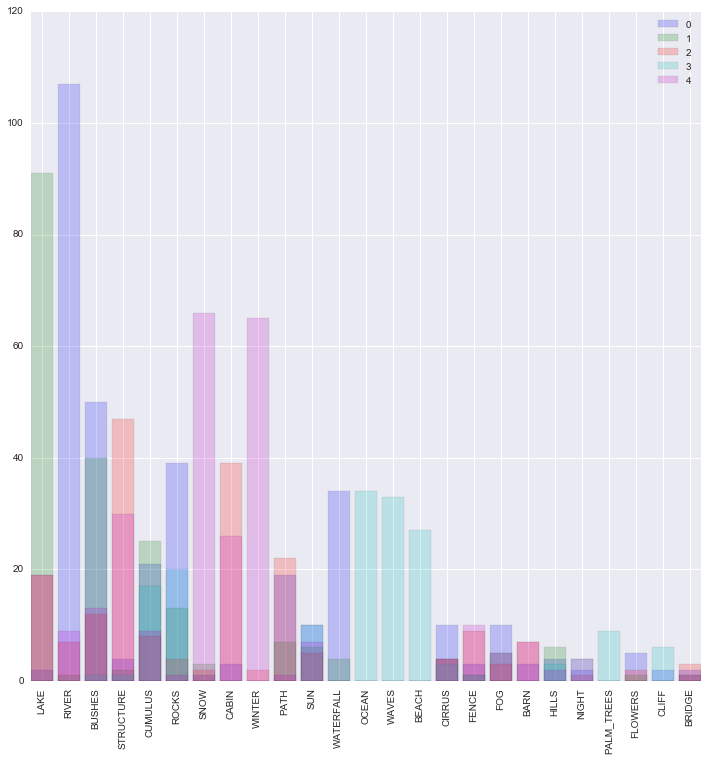

In [65]:
sorted_cols = [i[0] for i in count_occ(data).most_common()]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.xticks(np.arange(len(sorted_cols)), sorted_cols, rotation='vertical')
#plot_counts(count_occ(data), ax, sorted_cols)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

n_clusters = 5
k_means = KMeans(n_clusters=n_clusters)
clusters_by_index = k_means.fit_predict(data)
clusters = [data[clusters_by_index == i] for i in range(n_clusters)]


clusters_count = [df.sum() for df in clusters]
max_count = {key: max(ser.get(key, 0) for ser in clusters_count) for key in data.columns.values}

most_common_limit = 7

print('The %d most common features in each cluster' % most_common_limit)
for i, df in enumerate(clusters):
    print(i, count_occ(df).most_common(most_common_limit))
    plot_counts(count_occ(df), ax, sorted_cols, c=colors[i%len(colors)], label=str(i))

print()


# Hvis et cluster har flere tilfeller av et gitt motiv, lar vi motivet 'tilhøre' clusteret.

# Oppgave 3
print('The %d most common \'unique\' features')
for i, ser in enumerate(clusters_count):
    unique_dict = {key: value for key, value in ser.items() if value >= max_count[key]}
    print(i, Counter(unique_dict).most_common(most_common_limit))
    
plt.legend()
plt.show()

**Oppgave 1:** Klarer du å definere noen kategorier ut ifra utskriften?

**Oppgave 2:**
I utstkriften er det stort sannsynlighet for at noen variabler, for eksempel 'TREE' og 'TREES' forekommer mange ganger i hver av klusterne. Hvordan kan du tolke det?

**Oppgave 3:**
En løsning på problemet i forrige oppgave kan være å la et motiv tilhøre et kluster *kun* hvis det inneholder flere forekomster av motivet enn noen av de andre klusterne. Denne filtrerningen er gjort i koden i cellen over der det står "oppgave 3". Kommenter inn denne koden, og kjør cellen på nytt. Klarer du nå å lage bedre kategorier enn i oppgave 1? Hvordan kan filtreringen gjøre utskriften misvisende? Hint: Ta plottene i betraktning.

**Oppgave 4:**
En bedre løsning kan være å fjerne de motiver som forekommer i veldig mange bilder. Bruk utskriften nedenfor, og velg ut kolonner du synes burde fjernes. Navnene kan du legge til i listen 'common_columns' i den første cellen. Kjør deretter hele notebooken på nytt. Blir resultatene lettere å tolke?

**Oppgave 5:**
Prøv ut forskjellige antall clustere (endre `n_clusters`-variabelen). Hva skjer når du har mange, eller veldig få?

## Oversikt over de vanligste motivene ordene i `data`
Bruk denne listen i oppgave 4

In [60]:
l = len(data)
for word, count in count_occ(data).most_common():
    print('{: <10} {: 10.2f} %'.format(word, count/l*100))

TREE            90.55 %
TREES           84.51 %
DECIDUOUS       56.43 %
CONIFER         52.76 %
CLOUDS          43.83 %
MOUNTAIN        39.11 %
GRASS           35.96 %
LAKE            34.38 %
RIVER           32.55 %
BUSHES          30.45 %
SNOWY_MOUNTAIN      25.72 %
MOUNTAINS       23.88 %
STRUCTURE       22.05 %
CUMULUS         21.00 %
ROCKS           20.21 %
SNOW            18.90 %
CABIN           17.85 %
WINTER          17.59 %
PATH            12.86 %
SUN              9.97 %
WATERFALL        9.97 %
OCEAN            8.92 %
WAVES            8.66 %
BEACH            7.09 %
CIRRUS           6.56 %
FENCE            6.30 %
FOG              6.04 %
BARN             4.46 %
HILLS            3.94 %
NIGHT            2.89 %
PALM_TREES       2.36 %
FLOWERS          2.10 %
CLIFF            2.10 %
BRIDGE           1.84 %
